# 01 — Calendar Features

**Phase 2a: Feature Engineering**

## What you'll learn

- Why time-of-day and day-of-week are the **strongest demand signals** for electricity
- How to extract calendar features from a DatetimeIndex
- What Norwegian holidays look like in data
- How to visualize daily/weekly patterns

## Why calendar features matter

Electricity demand follows very predictable **human patterns**:
- People wake up → turn on lights, heating, coffee machines → demand rises at 6–8 AM
- Factories run during business hours → peak demand 8–17
- People go to sleep → demand drops after 22:00
- Weekends → factories closed, less commuting → demand drops 20–40%
- Holidays → similar to weekends

These patterns are **free features** — derived purely from timestamps, no API calls needed.

In [1]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

# Create an hourly time index for 2020–2026 in Norwegian timezone
hourly_index = pd.date_range(
    start="2020-01-01",
    end="2026-02-22",
    freq="h",
    tz="Europe/Oslo",
)
hourly_index.name = "timestamp"

print(f"Hourly index: {len(hourly_index):,} hours")
print(f"From: {hourly_index[0]}")
print(f"To:   {hourly_index[-1]}")
print(f"That's {len(hourly_index) / 24:.0f} days, or {len(hourly_index) / 8760:.1f} years")

Hourly index: 53,857 hours
From: 2020-01-01 00:00:00+01:00
To:   2026-02-22 00:00:00+01:00
That's 2244 days, or 6.1 years


## Step 1: Extract basic time components

pandas makes this easy — the DatetimeIndex has `.hour`, `.dayofweek`, `.month` etc. built in.

In [2]:
df = pd.DataFrame(index=hourly_index)

# Basic time components
df["hour_of_day"] = hourly_index.hour           # 0–23
df["day_of_week"] = hourly_index.dayofweek       # 0=Monday, 6=Sunday
df["month"] = hourly_index.month                  # 1–12
df["week_of_year"] = hourly_index.isocalendar().week.values  # 1–52

print("Sample of extracted features:")
df.head(30)

Sample of extracted features:


,hour_of_day,day_of_week,month,week_of_year
timestamp,,,,
2020-01-01 00:00:00+01:00,0,2,1,1
2020-01-01 01:00:00+01:00,1,2,1,1
2020-01-01 02:00:00+01:00,2,2,1,1
2020-01-01 03:00:00+01:00,3,2,1,1
2020-01-01 04:00:00+01:00,4,2,1,1
2020-01-01 05:00:00+01:00,5,2,1,1
2020-01-01 06:00:00+01:00,6,2,1,1
2020-01-01 07:00:00+01:00,7,2,1,1
2020-01-01 08:00:00+01:00,8,2,1,1


## Step 2: Binary flags

Binary (0/1) features are useful because they let the model learn **different behavior** for weekends vs weekdays, holidays vs normal days, etc.

For example, the model might learn:
- `price = base_price - 15 * is_weekend` (weekends are ~15 EUR/MWh cheaper)
- `price = base_price + 5 * is_business_hour` (business hours are 5 EUR/MWh more expensive)

In [3]:
# Weekend flag
df["is_weekend"] = (hourly_index.dayofweek >= 5).astype(int)

# Norwegian holidays using the 'holidays' library
no_holidays = holidays.Norway()
df["is_holiday"] = [int(d in no_holidays) for d in hourly_index.date]

# Business hours: 8–17 on weekdays
df["is_business_hour"] = (
    (hourly_index.hour >= 8)
    & (hourly_index.hour <= 17)
    & (hourly_index.dayofweek < 5)
).astype(int)

print(f"Weekend hours: {df['is_weekend'].sum():,} ({df['is_weekend'].mean():.1%})")
print(f"Holiday hours: {df['is_holiday'].sum():,} ({df['is_holiday'].mean():.1%})")
print(f"Business hours: {df['is_business_hour'].sum():,} ({df['is_business_hour'].mean():.1%})")

Weekend hours: 15,385 (28.6%)
Holiday hours: 1,751 (3.3%)
Business hours: 16,030 (29.8%)


## Step 3: What Norwegian holidays look like

Let's see which holidays the library knows about. These are important because electricity demand on holidays looks like weekends, not workdays.

In [4]:
# List all Norwegian holidays in our date range
no_hol = holidays.Norway(years=range(2020, 2027))

print(f"Norwegian public holidays (2020–2026): {len(no_hol)} days\n")
print("2025 holidays:")
for date, name in sorted(no_hol.items()):
    if date.year == 2025:
        weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][date.weekday()]
        print(f"  {date} ({weekday}): {name}")

Norwegian public holidays (2020–2026): 84 days

2025 holidays:
  2025-01-01 (Wed): Første nyttårsdag
  2025-04-17 (Thu): Skjærtorsdag
  2025-04-18 (Fri): Langfredag
  2025-04-20 (Sun): Første påskedag
  2025-04-21 (Mon): Andre påskedag
  2025-05-01 (Thu): Arbeidernes dag
  2025-05-17 (Sat): Grunnlovsdag
  2025-05-29 (Thu): Kristi himmelfartsdag
  2025-06-08 (Sun): Første pinsedag
  2025-06-09 (Mon): Andre pinsedag
  2025-12-25 (Thu): Første juledag
  2025-12-26 (Fri): Andre juledag


## Visualize: Daily demand pattern (hour of day)

Even without price data, we can show how our features capture the known demand pattern.

The classic electricity demand curve looks like:
- Low at night (0–6)
- Morning ramp (6–9)
- Peak during daytime (9–17)
- Evening peak (17–20, especially in winter)
- Decline to night (20–0)

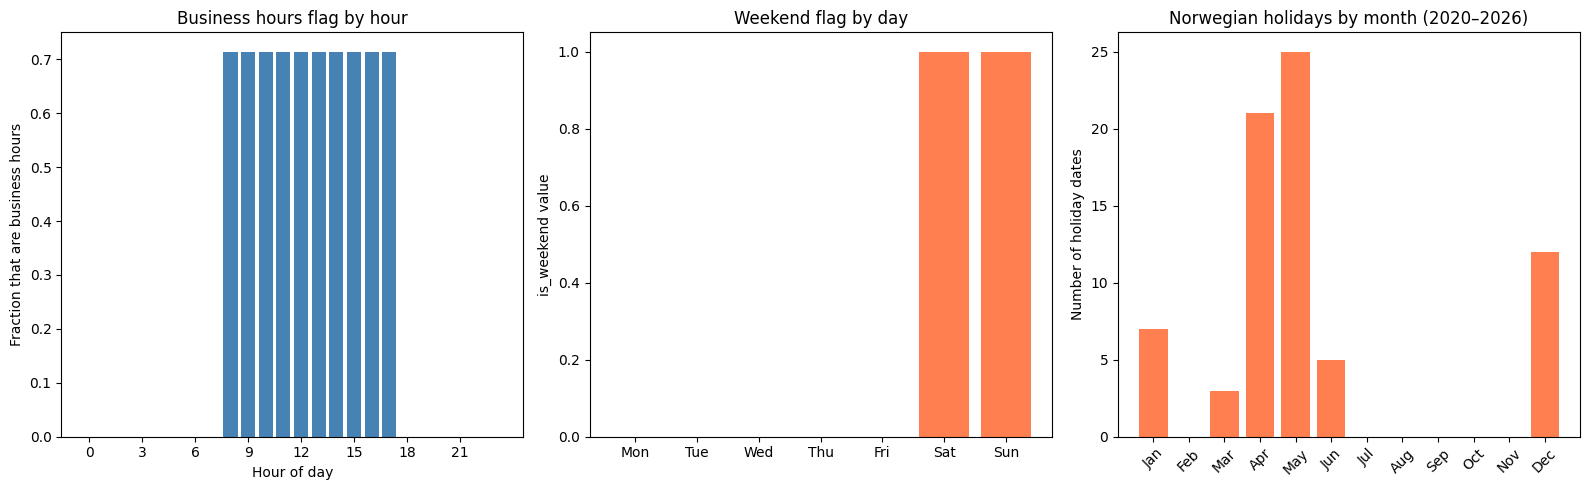

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: is_business_hour by hour
ax = axes[0]
hourly_avg = df.groupby("hour_of_day")["is_business_hour"].mean()
ax.bar(hourly_avg.index, hourly_avg.values, color="steelblue")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Fraction that are business hours")
ax.set_title("Business hours flag by hour")
ax.set_xticks(range(0, 24, 3))

# Panel 2: is_weekend by day of week
ax = axes[1]
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
daily_avg = df.groupby("day_of_week")["is_weekend"].mean()
colors = ["steelblue"] * 5 + ["coral"] * 2
ax.bar(daily_avg.index, daily_avg.values, color=colors)
ax.set_xticks(range(7))
ax.set_xticklabels(day_labels)
ax.set_ylabel("is_weekend value")
ax.set_title("Weekend flag by day")

# Panel 3: Holidays per month
ax = axes[2]
# Count unique holiday dates per month
holiday_dates = df[df["is_holiday"] == 1].index.date
holiday_months = pd.Series([d.month for d in set(holiday_dates)])
month_counts = holiday_months.value_counts().reindex(range(1, 13), fill_value=0)
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.bar(range(1, 13), month_counts.values, color="coral")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels, rotation=45)
ax.set_ylabel("Number of holiday dates")
ax.set_title("Norwegian holidays by month (2020–2026)")

plt.tight_layout()
plt.show()

## Visualize: Hour × Day-of-week heatmap

This shows how two features **interact**. In practice, when we have price data:
- Monday 8 AM will be expensive (morning ramp + workday)
- Sunday 3 AM will be cheap (night + weekend)

For now, we'll visualize the `is_business_hour` pattern to see the interaction.

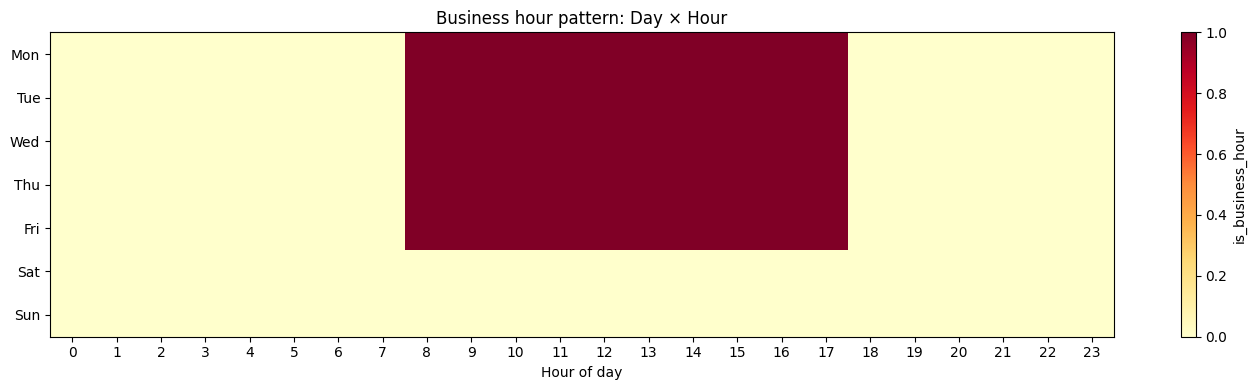

The yellow block (hours 8–17, Mon–Fri) is when electricity demand peaks.
This is why is_business_hour is such a useful feature.


In [6]:
# Create a heatmap: day_of_week × hour_of_day
pivot = df.pivot_table(
    values="is_business_hour",
    index="day_of_week",
    columns="hour_of_day",
    aggfunc="mean",
)

fig, ax = plt.subplots(figsize=(14, 4))
im = ax.imshow(pivot.values, aspect="auto", cmap="YlOrRd")
ax.set_yticks(range(7))
ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_xticks(range(24))
ax.set_xlabel("Hour of day")
ax.set_title("Business hour pattern: Day × Hour")
plt.colorbar(im, ax=ax, label="is_business_hour")
plt.tight_layout()
plt.show()

print("The yellow block (hours 8–17, Mon–Fri) is when electricity demand peaks.")
print("This is why is_business_hour is such a useful feature.")

## Using our build_features module

All of the above is packaged in `build_calendar_features()`. Let's verify it produces the same result.

In [7]:
from src.features.build_features import build_calendar_features

cal = build_calendar_features(hourly_index)
print(f"Shape: {cal.shape}")
print(f"Columns: {list(cal.columns)}")
print(f"Missing values: {cal.isna().sum().sum()}")
print(f"\nSample:")
cal.head(10)

ModuleNotFoundError: No module named 'src'

## Key takeaways

1. **Calendar features are free** — no API calls, no missing data, always available
2. **hour_of_day + day_of_week** are expected to be among the top 5 most important features
3. **is_weekend** captures the biggest demand pattern difference (~20-40% price drop)
4. **is_holiday** catches days like Christmas and Easter that behave like weekends
5. **month** captures seasonal patterns (winter heating, summer low demand)

**Next notebook:** 02_weather_features — how temperature and wind affect electricity prices

In [ ]:
from src.features.build_features import build_calendar_features

In [ ]:
import sys
from pathlib import Path

# Add project root to path so 'from src...' imports work
PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.features.build_features import build_calendar_features
print("Import successful!")

Import successful!
